In [10]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb
import cv2

In [11]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### Exercise 1: Binary image from original image
Read the image, convert it to grayscale and use Otsus method to compute and apply a threshold.

Show the binary image together with the original image.

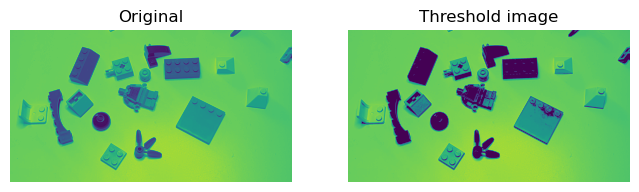

In [12]:
im_org = cv2.imread('lego_4_small.png', cv2.IMREAD_GRAYSCALE)
thresh = threshold_otsu(im_org)
ret, bin_img = cv2.threshold(im_org, 127, 255, thresh)
show_comparison(im_org, bin_img, 'Threshold image')

## Exercise 2: Remove border BLOBs
Use segmentation.clear_border to remove border pixels from the binary image.

In [13]:
segmentation.clear_border(bin_img)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 190, 190, ...,   0,   0,   0],
       [  0, 190, 193, ..., 183, 181,   0],
       ...,
       [  0, 193, 196, ...,   0,   0,   0],
       [  0,   0,   0, ..., 185, 187,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

## Exercise 3: Cleaning using morphological operations
In order to remove remove noise and close holes, you should do a morphological closing followed by a morphological opening with a disk shaped structuring element with radius 5.

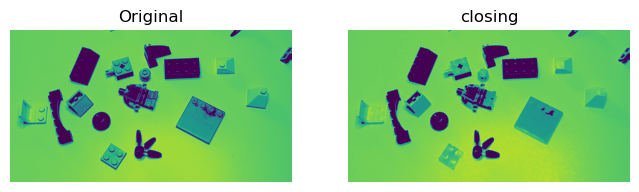

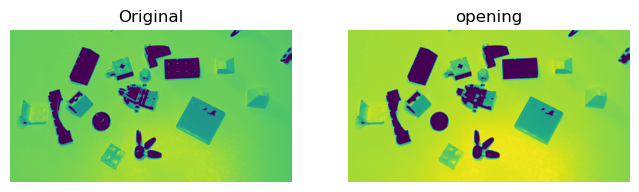

In [18]:
from skimage.morphology import erosion, dilation, opening, closing, disk

footprint = disk(5)

img_close = closing(bin_img, footprint)
show_comparison(bin_img, img_close, 'closing')

img_open = opening(img_close, footprint)
show_comparison(img_close, img_open, 'opening')

## Exercise 4: Find labels
The actual connected component analysis / BLOB analysis is performed using measure.label:

In [19]:
label_img = measure.label(img_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 31250


## Exercise 5: Visualize found labels
We can use the function label2rbg to create a visualization of the found BLOBS. Show this together with the original image.

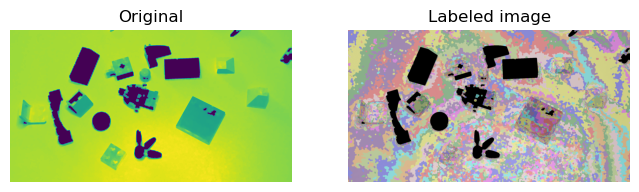

In [20]:
labeled_image = label2rgb(label_img, image=img_open, bg_label=0)
show_comparison(img_open, labeled_image, 'Labeled image')

## Exericse 6: Compute BLOB features
It is possible to compute a wide variety of BLOB features using the measure.regionprops function:

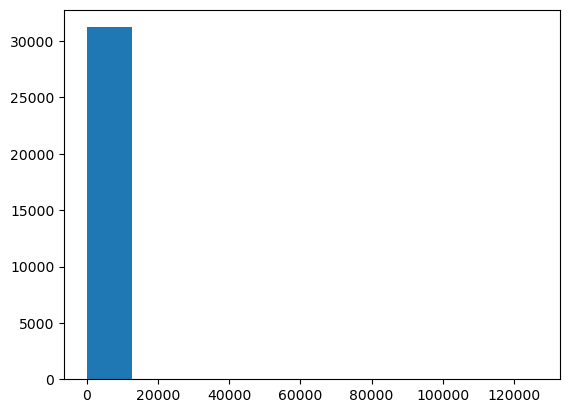

In [28]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=10)
plt.show()